# Table of Contents

* [1. Introduction](#introduction)
* [2. Loading the Data](#loading-data)
* [3. Data Analysis](#data-analysis)
    * [3.1 Missing Data](#missing-data)
    * [3.2 Age](#age)
        * [3.2.1 Filling missing Age values](#fill-age)
    * [3.3 Sex](#sex)
    * [3.4 Ticket class (Pclass)](#pclass)
    * [3.5 Port of Embarkation (Embarked)](#embarked)
    * [3.6 Fare](#fare)
* [4. Engineering Groups of Passengers](#engineer)
    * [4.1 Identifying groups of passengers](#identify-groups)
        * [4.1.1 Identifying groups by surname, PClass, ticket number (excluding last digit), and embarked (SPTE)](#spte)
        * [4.1.2 Identifying groups by ticket number](#ticket)
    * [4.2 Engineer InGroup](#ingroup)
    * [4.3 Engineer InWcg](#inwcg)
    * [4.4 Engineer WcgAllSurvived](#wcgallsurvived)
    * [4.5 Engineer WcgAllDied](#wcgalldied)
* [5. Modeling](#models)
    * [5.1 Cross-validation](#cv)
    * [5.2 Tunning hyper-parameters](#tuning)
        * [5.2.1 Logistic Regression](#logreg)
        * [5.2.2 SVC](#svc)
        * [5.2.3 K-nearest neighbors](#knn)
        * [5.2.4 Ada Boost](#ada)
        * [5.2.5 Extra Trees](#extra-trees)
    * [5.3 Ensemble modeling](#ensemble)
* [6. Predictions and submission](#submission)

#  1. Introduction <a class="anchor" id="introduction"></a>

As a newbie to datascience and a newcomer to Kaggle this is my first competition and kernel. *Titanic: Machine Learning from Disaster* seemed like the perfect competition to start with given the large amount of kernels that cover many of the skills I want to learn. Besides knowledge, those kernels were a source of inspiration and motivation as I was writing my own.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import jaccard_similarity_score

from scipy.stats import randint, uniform

from xgboost import XGBClassifier

import warnings


# Silence pesky deprecation warnings from sklearn
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
sns.set_palette('deep')
random_state = 1

# 2. Loading the Data <a class="anchor" id="loading-data"></a>

In [2]:
_train = pd.read_csv("train.csv")
_test = pd.read_csv("test.csv")

# Make a copy to be modified
train = _train.copy()
test = _test.copy()

In [3]:
train_len = len(train)
print("Training dataset size = {}".format(train_len))
train.head()

Training dataset size = 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_len = len(test)
print("Test dataset size = {}".format(test_len))
test.head()

Test dataset size = 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 3. Data Analysis <a class="anchor" id="data-analysis"></a>

Like most kernels, we will start by analyzing the features from the dataset, one-by-one, focusing on:
- Finding correlations, not only between each feature and survival but also between the features themselves to understand if the information the feature provides is not redundant.
- Creating visualizations that help us understand the data.
- Cleaning the dataset by removing redundant features.
- Filling missing data when needed.
- Converting data types when advantageous (e.g. converting categorical data to numerical).

In [5]:
# Remove PassengerId since it's not a feature
train.drop(columns='PassengerId', inplace=True)
test.drop(columns='PassengerId', inplace=True)

## 3.1 Missing data <a class="anchor" id="missing-data"></a>

In [6]:
# Concatenate the train and test datasets. Survived is not a feature so we drop it
dataset = pd.concat([train, test], sort=False).drop(columns='Survived')
pd.DataFrame({'No. NaN': dataset.isna().sum(), '%': dataset.isna().sum() / len(dataset)})

,%,No. NaN
Pclass,0.000000,0
Name,0.000000,0
Sex,0.000000,0
Age,0.200917,263
SibSp,0.000000,0
Parch,0.000000,0
Ticket,0.000000,0
Fare,0.000764,1
Cabin,0.774637,1014
Embarked,0.001528,2


Features with missing data:
- **Cabin (~77%)**: Drop. Too much data is missing to fill without introducing a significant amount of noise.
- **Age (~20%)**: Significant amount of data missing, but if it's useful we can try to fill it.
- **Fare (1 data point)**: Keep. Since only one value is missing we can fill it with something simple like a median.
- **Embarked (2 data points)**: Keep. Since only two values are missing we can fill them with something simple like a median.

In [7]:
train.drop(columns='Cabin', inplace=True)
test.drop(columns='Cabin', inplace=True)

## 3.2 Age <a class="anchor" id="age"></a>

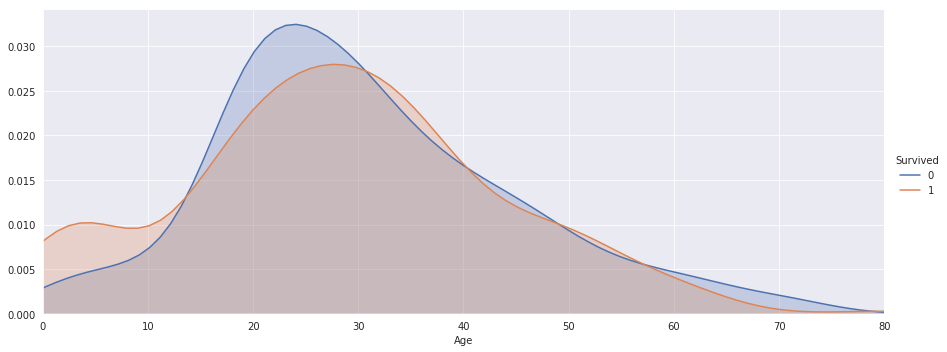

In [8]:
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Age', shade=True)
    g.add_legend()
    g.set(xlim=(0, train['Age'].max()))

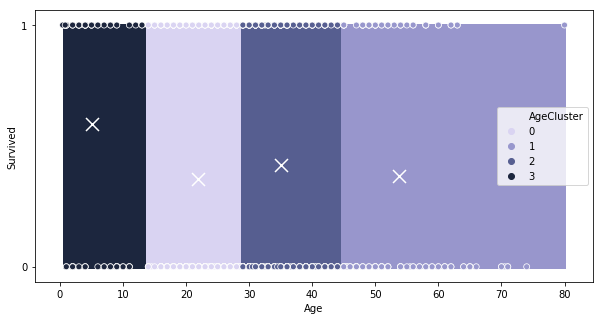

In [9]:
num_clusters = 4
X = train[[ 'Age', 'Survived']].dropna()
kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
kmeans.fit(X)
X['AgeCluster'] = kmeans.labels_

# Plot the decision boundary. See http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
plt.figure(figsize=(10,5))
h = 0.01
x_min, x_max = X['Age'].min() - h, X['Age'].max() + h
y_min, y_max = X['Survived'].min() - h, X['Survived'].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
cmap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=cmap, aspect='auto')

sns.scatterplot(x='Age', y='Survived', hue='AgeCluster', data=X, palette=cmap)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w')
plt.yticks([0, 1])
plt.show()

In [10]:
# Convert K-means clusters to age bands
age_bands = []
for k in range(num_clusters):
    age_bands.append(xx[Z==k].min())

# Since the clusters are not sorted we sort the intervals
age_bands.sort()

# Set the lower bound of the first interval to 0
age_bands[0] = 0

# Set the higher bound of the last interval to infinite just in case there are older older passengers in the test set
age_bands.append(np.inf)

# Convert list to numpy array
print("Age bands: {}".format(np.array(age_bands)))

Age bands: [ 0.   13.47 28.52 44.4    inf]


In [11]:
# Use both the training and test dataset to fill the missing Age values
dataset = pd.concat([train, test], sort=True)
dataset['AgeBand'] = pd.cut(dataset['Age'], age_bands)

dataset.groupby('AgeBand')['Survived'].mean()

AgeBand
(0.0, 13.47]      0.591549
(13.47, 28.52]    0.361775
(28.52, 44.4]     0.421277
(44.4, inf]       0.373913
Name: Survived, dtype: float64

Observations:
- Children (age < 13.47) have much higher chances of survival (59.2%).
- Passengers between the ages of 28.52 and 44.4 also show better survival rates than the remaining two groups

### 3.2.1 Filing missing Age values <a class="anchor" id="fill-age"></a>

To fill the missing 20% age values, we are going to estimate the age band using the most accurate of the following classifiers:
- Logistic regression
- K-nearest neighbors
- Decision tree

with the following features:
- Age
- Pclass
- SibSp
- Parch
- Sex
- Title (engineered from Name)

There are many ways to fill the missing ages, I chose this one simply because it was an excuse to do more some stuff with models and it worked well enough.

#### Feature selection

In [12]:
# Use both the training and test dataset to fill the missing Age values
fill_age_df = dataset[['Name', 'AgeBand', 'Pclass', 'SibSp', 'Parch', 'Sex']].copy()

# Get the titles of the passengers
fill_age_df['Title'] = fill_age_df['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])

pd.crosstab(fill_age_df['Title'], fill_age_df['Sex']).transpose()

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [13]:
# Join Mlle (Mademoiselle) and Ms with Miss - Mlle and Miss both indicate a unmarried status while Ms is more generic
# it can mean both Miss and Mrs, I chose Miss because it's more frequent
fill_age_df['Title'].replace(to_replace=['Mlle', 'Ms'], value='Miss', inplace=True)

# Join Mme (Madame) with Mrs - Mme and Mrs both indicate a married status
fill_age_df['Title'].replace(to_replace='Mme', value='Mrs', inplace=True)

# Join the remaining titles with low frequencies
fill_age_df['Title'].replace(to_replace=['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir',
                                         'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                             value='Rare', inplace=True)

title_dummies = pd.get_dummies(fill_age_df['Title'], drop_first=True)
fill_age_df = pd.concat([fill_age_df, title_dummies], axis=1)
fill_age_df.head(2)

,Name,AgeBand,Pclass,SibSp,Parch,Sex,Title,Miss,Mr,Mrs,Rare
0,"Braund, Mr. Owen Harris","(13.47, 28.52]",3,1,0,male,Mr,0,1,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...","(28.52, 44.4]",1,1,0,female,Mrs,0,0,1,0


In [14]:
# Encode ages and sex
fill_age_df['IsMale'] = fill_age_df['Sex'].astype('category').cat.codes
fill_age_df['AgeBand'] = fill_age_df['AgeBand'].astype('category').cat.codes

# Drop columns we no longer need
fill_age_df.drop(columns=['Name', 'Sex', 'Title'], inplace=True)

fill_age_df.head(2)

,AgeBand,Pclass,SibSp,Parch,Miss,Mr,Mrs,Rare,IsMale
0,1,3,1,0,0,1,0,0,1
1,2,1,1,0,0,0,1,0,0


Convert the dataset in training samples, training labels, and testing samples.

In [15]:
# Drop all rows with unknown age bands (-1) from the training set
X_train = fill_age_df.loc[fill_age_df['AgeBand'] != -1].drop(columns='AgeBand')
Y_train = fill_age_df['AgeBand'].loc[fill_age_df['AgeBand'] != -1]

# Get all rows with unknown age bands (-1) for the test set
X = fill_age_df.loc[fill_age_df['AgeBand'] == -1].drop(columns='AgeBand')

# Some shapes to double-check
print("Training samples shape: {}".format(X_train.shape))
print("Training labels shape: {}".format(Y_train.shape))
print("Samples to predict shape: {}".format(X.shape))

Training samples shape: (1046, 8)
Training labels shape: (1046,)
Samples to predict shape: (263, 8)


#### Age band modeling
Create three simple classifier models and use cross-validation to analyze which is better.

In [16]:
logreg = LogisticRegression(random_state=random_state)
logreg_scores = cross_val_score(logreg, X_train, Y_train, cv=10)
print("Logistic Regression cross-validation scores: {:.3f}".format(logreg_scores.mean()))

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, Y_train, cv=10)
print("KNeighbors cross-validation scores: {:.3f}".format(knn_scores.mean()))

tree = DecisionTreeClassifier(random_state=random_state)
tree_scores = cross_val_score(tree, X_train, Y_train, cv=10)
print("Tree Classifier cross-validation scores: {:.3f}".format(tree_scores.mean()))

Logistic Regression cross-validation scores: 0.536
KNeighbors cross-validation scores: 0.517
Tree Classifier cross-validation scores: 0.561


The most accurate age band classifier is the Decision Tree; use it to predict the age bands.

In [17]:
# Make predictions using our best model (Decision Tree)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_train)

# Compute the per-class/per-age band accuracy
total = np.bincount(Y_train.values, minlength=4)
correct = np.bincount(Y_pred[Y_pred == Y_train.values], minlength=4)
class_acc = correct / total
pd.DataFrame({'AgeBand': np.arange(4),
              'AgeInterval': dataset['AgeBand'].cat.categories,
              'PerClassAcc.': class_acc})

,AgeBand,AgeInterval,PerClassAcc.
0,0,"(0.0, 13.47]",0.959596
1,1,"(13.47, 28.52]",0.845455
2,2,"(28.52, 44.4]",0.320242
3,3,"(44.4, inf]",0.488636


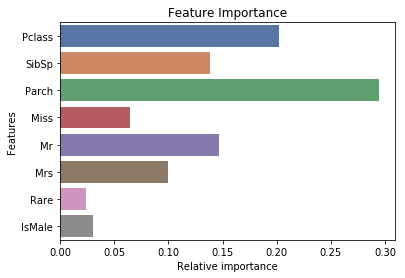

In [18]:
# Feature importance
g = sns.barplot(x=tree.feature_importances_, y=X.columns, orient='h')
_ = g.set_xlabel('Relative importance')
_ = g.set_ylabel('Features')
_ = g.set_title('Feature Importance')

Overall, none of the models achieves high-accuracy; however, if we check the per-class/per-age band accuracy, we see that our best model (Decision Tree) is really good at predicting children - 95.7% accuracy for passengers between the ages of 0 and 8. As discussed previously, this is the most relevant age band; therefore, a low overall accuracy shouldn't be a big issue as long as we have high accuracy in this age band.

It also shows that the model can make good predictions for passengers between the ages of 16 and 24. A possible explanation is that passengers within this age band are more likely to be traveling with friends or alone, therefore SibSp and Parch are 0 making them easier to classify.

We can now predict the age band for passengers with missing data:

In [19]:
Y = tree.predict(X)
fill_age_df.loc[fill_age_df['AgeBand'] == -1, 'AgeBand'] = Y

Apply the integer encoded age bands to the train and test datasets.

In [20]:
train['AgeBand'] = fill_age_df.iloc[:train_len, 0]
test['AgeBand'] = fill_age_df.iloc[train_len:, 0]

# Remove Age column
train.drop(columns='Age', inplace=True)
test.drop(columns='Age', inplace=True)

train.head(2)

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,AgeBand
0,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,2


## 3.3 Sex <a class="anchor" id="sex"></a>

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

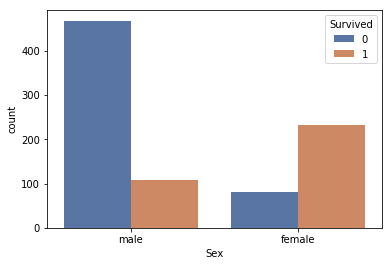

In [21]:
_ = sns.countplot(x='Sex', hue='Survived', data=train)
train.groupby('Sex')['Survived'].mean()

Females have much higher survival rates. One-hot encode `Sex` so all machine algorithms can handle it.

In [22]:
# One-encode using dummies
train['IsMale'] = pd.get_dummies(train['Sex'], drop_first=True)
test['IsMale'] = pd.get_dummies(test['Sex'], drop_first=True)

# Drop the Sex column
train.drop(columns='Sex', inplace=True)
test.drop(columns='Sex', inplace=True)

## 3.4 Ticket class (Pclass) <a class="anchor" id="pclass"></a>

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

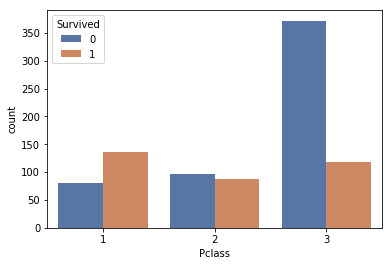

In [23]:
_ = sns.countplot(x='Pclass', hue='Survived', data=train)
train.groupby('Pclass')['Survived'].mean()

Passengers with higher ticket class (lower `Pclass`) have higher chances of survival:
- 1st class: 63%
- 2nd class: 48%
- 3rd class: 24%

Keep the feature as-is, `Pclass` is already encoded in integers (one-hot encoding would leave out the natural order of ticket class which is an important part of the feature).

## 3.5 Port of Embarkation (Embarked) <a class="anchor" id="embarked"></a>

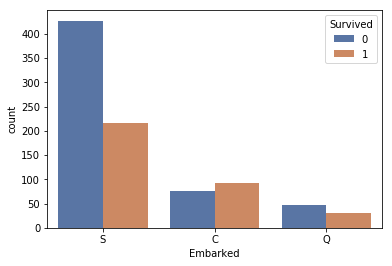

In [24]:
_ = sns.countplot(x='Embarked', hue='Survived', data=train)

After looking at this chart my first thought was that it was a useful feature, we can see that passengers from different ports have varying chances of survival. Great!

Then, after thinking some more I was convinced that there shouldn't be a correlation between the port of embarkation and survival. I think that what this chart shows is just the combination of `IsMale` and `Pclass`.

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


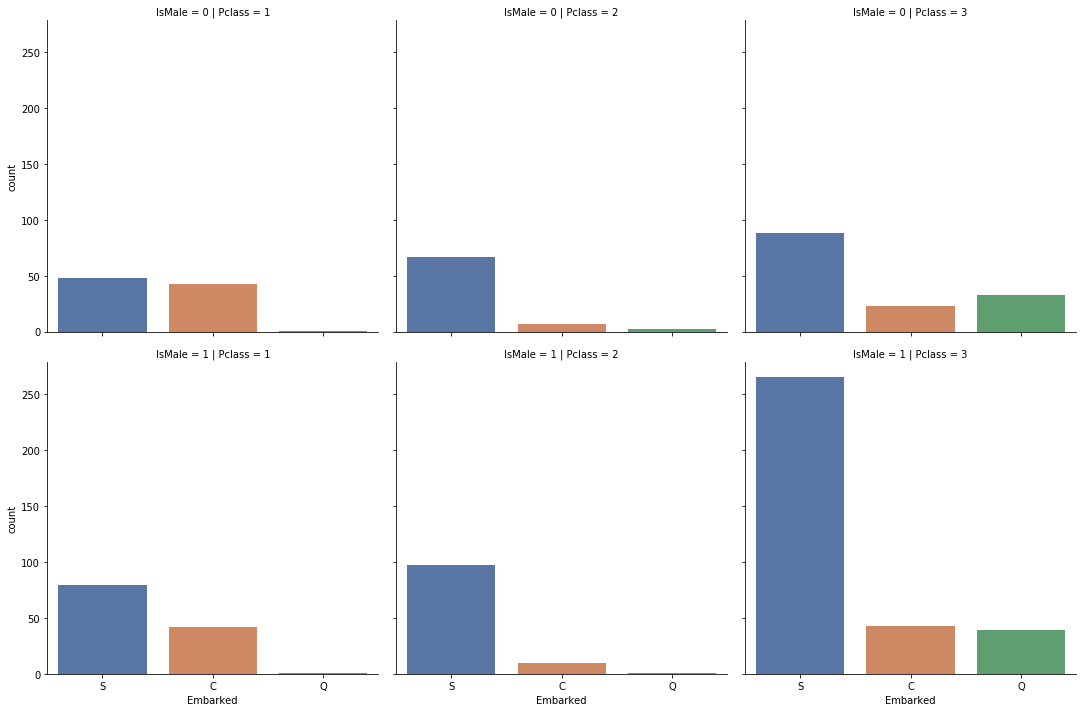

In [25]:
# Plot relationship between Embarked, Pclass, and IsMale
_ = sns.factorplot(x='Embarked', col='Pclass', row='IsMale', data=train, kind='count')

In [26]:
# Passengers grouped by Embarked, Pclass, and IsMale
embarked_corr = (train[['Survived', 'Embarked', 'Pclass', 'IsMale']].groupby(['Embarked', 'Pclass', 'IsMale'])                                            
                                                                    .agg(['count', 'sum', 'mean']))
embarked_corr.columns = embarked_corr.columns.droplevel(0)
embarked_corr.columns = ['Total', 'Survived', 'Rate']
embarked_corr

Total  Survived      Rate
Embarked Pclass IsMale                           
C        1      0          43        42  0.976744
                1          42        17  0.404762
         2      0           7         7  1.000000
                1          10         2  0.200000
         3      0          23        15  0.652174
                1          43        10  0.232558
Q        1      0           1         1  1.000000
                1           1         0  0.000000
         2      0           2         2  1.000000
                1           1         0  0.000000
         3      0          33        24  0.727273
                1          39         3  0.076923
S        1      0          48        46  0.958333
                1          79        28  0.354430
         2      0          67        61  0.910448
                1          97        15  0.154639
         3      0          88        33  0.375000
                1         265        34  0.128302

We see that in `Southampton (S)` a high number of 3rd class males embarked on the Titanic, so a low survival rate is to be expected. A high number of 1st class passengers embarked in `Cherbourg (C)`, so we see a high survival rate. In `Queenstown (Q)`, however, the chart shows something that I was not expecting given the following observations:
- the vast majority of passengers are 3rd class passengers;
- the number of males and females is comparable.

Given these conditions, the survival rate should be correlated only to `IsMale`, and that is true for females; males however end-up with half the survival rate. Though this is a sample of 42 males in a population of 577, it's not enough to convince me that `Embarked` is independently correlated with survival.

In [27]:
train.drop(columns='Embarked', inplace=True)
test.drop(columns='Embarked', inplace=True)

## 3.6 Fare <a class="anchor" id="fare"></a>
Despite the fact that the [Titanic: Machine Learning from Disaster data page](https://www.kaggle.com/c/titanic/data) states that `Fare` is the passenger fare, I'm convinced that it's actually the ticket fare. Therefore, we will devide `Fare` by the ticket frequency (`TicketFreq`) to compute the actual passenger fare (`PassengerFare`).

In [28]:
dataset = pd.concat([train, test], sort=True)
dataset['TicketFreq'] = dataset.groupby('Ticket')['Ticket'].transform('count')
dataset['PassengerFare'] = dataset['Fare'] / dataset['TicketFreq']

# Add PassengerFare to the training and test sets
train['PassengerFare'] = dataset['PassengerFare'].iloc[:train_len]
test['PassengerFare'] = dataset['PassengerFare'].iloc[train_len:]
train.head(2)

,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,AgeBand,IsMale,PassengerFare
0,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,1,1,7.25000
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,2,0,35.64165


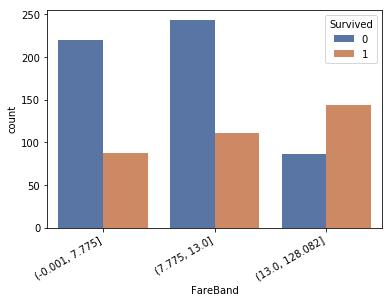

In [29]:
num_fare_bins = 3
train['FareBand'], fare_bins = pd.qcut(train['PassengerFare'], num_fare_bins, retbins=True)
_ = sns.countplot(x='FareBand', hue='Survived', data=train)
_ = plt.xticks(rotation=30, ha='right')

We see that as `Fare` increases, the survival rate also increases, awesome...well, it's also likely that this feature is highly related to `Pclass`, lower `Pclass` should translate to higher `PassengerFare`. 

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


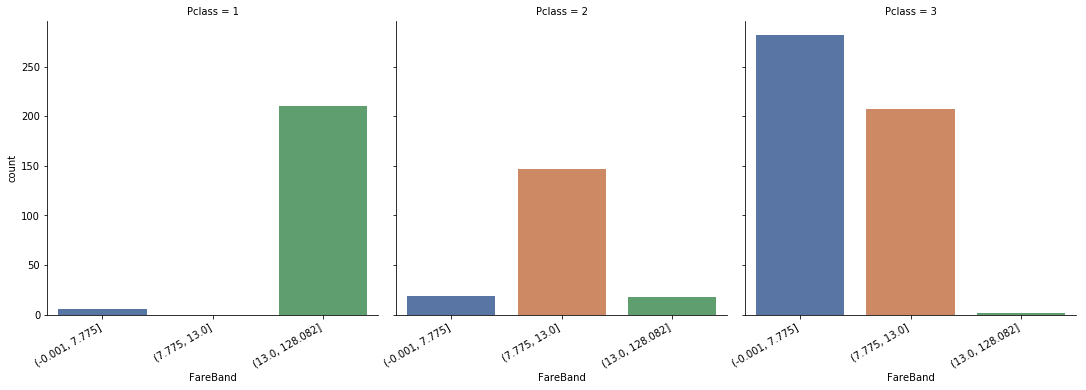

In [30]:
# Plot relationship between FareBand and Pclass
g = sns.factorplot(x='FareBand', col='Pclass', data=train, kind='count')
_ = g.set_xticklabels(rotation=30, ha='right')

`FareBand` describes `Pclass` 1 and 2 almost perfectly. But why are there so many passengers with `Pclass = 3` tickets with fares expected for `Pclass = 2`? Let's compare the mean and standard deviation of passengers with `Pclass = 2 & FareBand = (7.775, 13.0]` and `Pclass = 3 & FareBand = (7.775, 13.0]`

In [31]:
interval = pd.Interval(left=7.775, right=13.0)
mask = (train['FareBand'] == interval) & (train['Pclass'] != 1)
train.loc[mask, ['Pclass', 'PassengerFare']].groupby('Pclass').agg(['mean', 'std'])

PassengerFare          
                mean       std
Pclass                        
2          11.663122  1.490713
3           8.253337  0.569403

The table shows that passengers with 3rd class tickets paid, on average, a fare of 8.25, close to the lower bound of thi fare range ((7.775, 13]). Passengers with 2nd class tickets paid on average 11.66, close to the upper bound. The standard deviation is also much lower for 3rd class passengers.

From these observations, I think that many of the 3rd class passengers in this fare range belong to groups where one or more members (given the low standard deviation one is more likely) are not in the public dataset. Missing a passenger in a ticket group translates into a lower `TicketFreq` and a higher `PassengerFare`/`Fare`.

In conclusion, if we had the complete dataset `PassengerFare`/`Fare` would describe `Pclass`. Therefore, we'll drop `FareBand` and keep `Pclass`.

In [32]:
train.drop(columns=['Fare', 'PassengerFare', 'FareBand'], inplace=True)
test.drop(columns=['Fare', 'PassengerFare'], inplace=True)

train.head(2)

,Survived,Pclass,Name,SibSp,Parch,Ticket,AgeBand,IsMale
0,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,2,0


# 4. Engineering Groups of Passengers <a class="anchor" id="engineer"></a>

Many kernels have explored `SibSp` and `Parch` to engineer family related features. However, in recent months the top kernels have found that `SibSp` and `Parch` contain inconsistencies (see the excellent work by [Erik Bruin](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting)) and that looking at groups of passengers travelling together instead of just families yields better results (see [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever), [Titanic \[0.82\] - \[0.83\]](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83), [Titanic using Name only \[0.81818\]](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook), and [Titantic Mega Model - \[0.84210\]
](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210) for some great work using groups of passengers).

With this knowledge we are going to engineer four new features derived from groups of passengers:
- `InGroup`: the passenger is traveling with other passengers or not;
- `InWcg`: the passenger is a member of a woman-child group or not;
- `WcgAllSurvived`: whether the members of the woman-child group all survived;
- `WcgAllDied`: whether the members of the woman-child group all died.

## 4.1 Identifying groups of passengers <a class="anchor" id="identify-groups"></a>

To engineer these features we first have to define what's a group and identify which passengers belong to which group. Similarly to [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever) we are going to define a group as a set of passengers that all share at least one of the following conditions (inspired by [Titantic Mega Model - \[0.84210\]
](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210)):
1. Combination of: surname, PClass, ticket number (excluding the last digit), and embarked;
2. Ticket number.

The first condition will identify mostly families while the second will identify groups of friends that share the same ticket, or even passengers traveling with families (e.g. maidens).

In [33]:
# Create the new feature for the whole dataset 
# (I am using _train and _test because train and test no longer contain 'Embarked')
dataset = pd.concat([_train, _test], sort=True, ignore_index=True)

### 4.1.1 Identifying groups by surname, Pclass, ticket number (excluding last digit), and embarked (SPTE) <a class="anchor" id="spte"></a>

In [34]:
surname = dataset['Name'].apply(lambda x: x[:x.find(',')])
ticket = dataset['Ticket'].apply(lambda x: x[:-1])

dataset['SPTE'] = (surname.astype(str) + '-' + dataset['Pclass'].astype(str) + '-'
           + ticket.astype(str) + '-' + dataset['Embarked'].astype(str))

spte_count = dataset['SPTE'].value_counts(sort=False)

def spte_group_lebeler(group):
    group_elements = dataset.loc[dataset['SPTE'] == group, 'PassengerId']
    if len(group_elements) == 1:
        return 0
    else:
        return group_elements.min()

dataset['GroupId'] = dataset['SPTE'].apply(spte_group_lebeler)
dataset.drop(columns='SPTE', inplace=True)
dataset.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,GroupId
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,0
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,0
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,0
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,0
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,129



### 4.1.2 Identifying groups by ticket number <a class="anchor" id="ticket"></a>

In [35]:
# Groups that share the same ticket number
def ticket_group_labeler(group):
    unique_groups = group.unique()
    if len(unique_groups) == 1:
        return unique_groups[0]
    elif len(unique_groups) == 2 and min(unique_groups) == 0:
        return dataset.loc[group.index, 'PassengerId'].min()
    else:
        raise ValueError("Found conflict between SPTE and ticket grouping:\n\n{}".format(dataset.loc[group.index]))

dataset['GroupId'] = dataset.groupby('Ticket')['GroupId'].transform(ticket_group_labeler)
dataset.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,GroupId
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,0
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,308
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,0
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,0
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,129


## 4.2 Engineer InGroup <a class="anchor" id="ingroup"></a>

`InGroup` is `1` if the passenger is in a group (`GroupId` is not unique); otherwise is `0`.

InGroup
0    0.315175
1    0.477454
Name: Survived, dtype: float64

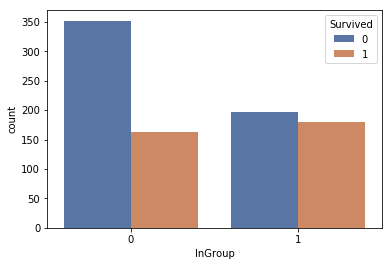

In [36]:
# Calculate the size of each group
dataset['GroupSize'] = dataset.groupby('GroupId')['GroupId'].transform('count')
dataset.loc[dataset['GroupId'] == 0, 'GroupSize'] = 1

# InGroup is 1 for groups with more than one member
dataset['InGroup'] = (dataset['GroupSize'] > 1).astype(int)

# Add to the train and test datasets
train['InGroup'] = dataset.iloc[:train_len, -1]
test['InGroup'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

_ = sns.countplot(x='InGroup', hue='Survived', data=train)
train.groupby('InGroup')['Survived'].mean()

## 4.3 Engineer InWcg <a class="anchor" id="inwcg"></a>

Woman-child-groups are groups of passengers traveling together whose members are either females or boys (males with a `Master` title). Chris Deotte found that members of woman-child-groups are more likely to share the same fate than other groups. He presented the idea in [Titanic using Name only \[0.81818\]](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook) and perfected the definition of these groups in [Titantic Mega Model - \[0.84210\]
](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210).

`InWcg` is `1` if the passenger is in a woman-child-group; otherwise is `0`.

In [37]:
# Get the titles of the passengers
dataset['Title'] = dataset['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])

# Create a mask to account only for females or boys in groups
mask = (dataset['GroupId'] != 0) & ((dataset['Title'] == 'Master') | (dataset['Sex'] == 'female'))

# Get the number of females and boys in each group, discard groups with only one member
wcg_groups = dataset.loc[mask, 'GroupId'].value_counts()
wcg_groups = wcg_groups[wcg_groups > 1]

# Update the mask to discard groups with only one female or boy
mask = mask & (dataset['GroupId'].isin(wcg_groups.index))

# Create the new feature using the updated mask
dataset['InWcg'] = 0
dataset.loc[mask, 'InWcg'] = 1

print("Number of woman-child-groups found:", len(wcg_groups))
print("Number of passengers in woman-child-groups:", len(dataset.loc[dataset['InWcg'] == 1]))

# Add to the train and test datasets
train['InWcg'] = dataset.iloc[:train_len, -1]
test['InWcg'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

Number of woman-child-groups found: 94
Number of passengers in woman-child-groups: 257


## 4.4 Engineer WcgAllSurvived <a class="anchor" id="wcgallsurvived"></a>

For a given passenger in a woman-child-group, `WcgAllSurvived` is equal to `1` if all members of that group survived; otherwise is `0`. 

Note that passengers from the test set are ignored. `AllSurvived` is based on the training set data only.

In [38]:
dataset['WcgAllSurvived'] = dataset.loc[dataset['InWcg'] == 1].groupby('GroupId')['Survived'].transform(np.nanmean)

# `np.nanmean` returns NaN for groups without survival information (test set only groups)
# Replace the NaN with 0
dataset.loc[dataset['WcgAllSurvived'].isna(), 'WcgAllSurvived'] = 0
dataset['WcgAllSurvived'] = dataset['WcgAllSurvived'].astype(int)

# Add to the train and test datasets
train['WcgAllSurvived'] = dataset.iloc[:train_len, -1]
test['WcgAllSurvived'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:3652: RuntimeWarning: Mean of empty slice
  wrapper = lambda x: func(x, *args, **kwargs)


## 4.5 Engineer WcgAllDied <a class="anchor" id="wcgalldied"></a>

`WcgAllDied` is just the opposite of `WcgAllSurvived`. For a given passenger in a woman-child-group, `WcgAllDied` is equal to `1` if all members of that group died; otherwise is `0`. 

In [39]:
dataset['WcgAllDied'] = (1 - dataset.loc[dataset['InWcg'] == 1].groupby('GroupId')['Survived'].transform(np.nanmean))

# `np.nanmean` returns NaN for groups without survival information (test set only groups)
# Replace the NaN with 0
dataset.loc[dataset['WcgAllDied'].isna(), 'WcgAllDied'] = 0
dataset['WcgAllDied'] = dataset['WcgAllDied'].astype(int)

# Add to the train and test datasets
train['WcgAllDied'] = dataset.iloc[:train_len, -1]
test['WcgAllDied'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:3652: RuntimeWarning: Mean of empty slice
  wrapper = lambda x: func(x, *args, **kwargs)


We can now drop `Name`, `SibSp`, `Parch`, and `Ticket` since we will no longer need them.

In [40]:
train.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)
test.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)

# 5. Modeling <a class="anchor" id="models"></a>

Let's do one last check on out features. The training set:

In [41]:
train.head()

,Survived,Pclass,AgeBand,IsMale,InGroup,InWcg,WcgAllSurvived,WcgAllDied
0,0,3,1,1,0,0,0,0
1,1,1,2,0,1,0,0,0
2,1,3,1,0,0,0,0,0
3,1,1,2,0,1,0,0,0
4,0,3,2,1,0,0,0,0


The test set:

In [42]:
test.head()

,Pclass,AgeBand,IsMale,InGroup,InWcg,WcgAllSurvived,WcgAllDied
0,3,2,1,0,0,0,0
1,3,3,0,0,0,0,0
2,2,3,1,0,0,0,0
3,3,1,1,0,0,0,0
4,3,1,0,1,1,1,0


## 5.1 Cross-validation <a class="anchor" id="cv"></a>

Evaluate, using cross-validation, which of the following classifiers performs best with our training data:
- Decision Tree
- Random Forest
- Extra Trees
- AdaBoost
- Logistic Regression
- K-nearest neighbors
- SVC
- Gradient Boosting
- eXtreme Gradient Boosting

In [43]:
# Split the training set into samples and targets
X_train = train.drop(columns='Survived')
Y_train = train['Survived'].astype(int)

# Test set samples to predict
X_test = test

# Scale features such that the mean is 0 and standard deviation is 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Number of cross-validation folds
k_folds = 10

# Number of estimators for tree based ensembles
n_estimators = 100

# Create a dictionary containing the instance of the models, scores, mean accuracy and standard deviation
classifiers = {
    'name': ['DecisionTree', 'RandomForest', 'ExtraTrees', 'AdaBoost', 'LogReg', 'KNN', 'SVC',
             'XGBoost', 'GradientBoost'],
    'models': [DecisionTreeClassifier(random_state=random_state),
               RandomForestClassifier(random_state=random_state, n_estimators=n_estimators),
               ExtraTreesClassifier(random_state=random_state, n_estimators=n_estimators),
               AdaBoostClassifier(random_state=random_state, n_estimators=n_estimators),
               LogisticRegression(random_state=random_state),
               KNeighborsClassifier(),
               SVC(random_state=random_state),
               XGBClassifier(random_state=random_state, n_estimators=n_estimators),
               GradientBoostingClassifier(random_state=random_state, n_estimators=n_estimators)], 
    'scores': [],
    'acc_mean': [],
    'acc_std': []
}

# Run cross-validation and store the scores
for model in classifiers['models']:
    score = cross_val_score(model, X_train, Y_train, cv=k_folds, n_jobs=4)
    classifiers['scores'].append(score)
    classifiers['acc_mean'].append(score.mean())
    classifiers['acc_std'].append(score.std())    

# Create a nice table with the results
classifiers_df = pd.DataFrame({
    'Model Name': classifiers['name'],
    'Accuracy': classifiers['acc_mean'],
    'Std': classifiers['acc_std']
}, columns=['Model Name', 'Accuracy', 'Std']).set_index('Model Name')

classifiers_df.sort_values('Accuracy', ascending=False)

,Accuracy,Std
Model Name,,
LogReg,0.861907,0.035316
SVC,0.860783,0.034286
KNN,0.856377,0.033493
AdaBoost,0.850720,0.024547
DecisionTree,0.848511,0.028815
RandomForest,0.848511,0.028815
ExtraTrees,0.848511,0.028815
XGBoost,0.843991,0.031932
GradientBoost,0.842855,0.027965


From the tested models we'll keep the best five:
- Logistic Regression
- SVC
- K-nearest neighbors
- AdaBoost
- Extra Trees (Decision Tree, Random Forest, and Extra Trees all share the same CV score. Random Forest and Extra Trees tend to perform better as they are ensembles of Decision Trees; between Random Forest and Extra Trees there isn't much of a difference, so I decided to go with Extra Trees)

## 5.2 Tunning hyper-parameters <a class="anchor" id="tuning"></a>

To further improve the models we can tune their hyper-parameters using randomized parameter optimization or grid search. I chose randomized parameter optimization because it typically performs just as well as grid search but with much fewer iterations, furthermore, the number of iterations in a parameter that we control. Obviously, more iterations are always better but if we want to make quick tests we can easily reduce the tuning time by lowering this parameter instead of reducing all of the hyper-parameter search ranges.

In [44]:
# Utility function to report best scores
# Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
def report(results, n_top=3, limit=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        if limit is not None:
            candidates = candidates[:limit]
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print()

# Number of iterations
n_iter_search = 200

### 5.2.1 Logistic Regression <a class="anchor" id="logreg"></a>

In [45]:
logreg = LogisticRegression(random_state=random_state)
rand_param = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.01, 10)
 }

logreg_search = RandomizedSearchCV(logreg, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                   n_jobs=4, verbose=1, iid=False)
logreg_search.fit(X_train, Y_train)
report(logreg_search.cv_results_)

logreg_best = logreg_search.best_estimator_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.8619 (std: 0.0353)
Parameters: {'C': 1.0659500668345212, 'penalty': 'l2'}

Model with rank: 1
Mean validation score: 0.8619 (std: 0.0353)
Parameters: {'C': 0.8331898963479889, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.8619 (std: 0.0353)
Parameters: {'C': 2.0773593103008756, 'penalty': 'l1'}



[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    2.5s finished


### 5.2.2 SVC <a class="anchor" id="svc"></a>

In [46]:
svc = SVC(random_state=random_state, probability=True)
rand_param = {
    'C': uniform(0.01, 10),
    'gamma': uniform(0.01, 10)
 }

svc_search = RandomizedSearchCV(svc, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
svc_search.fit(X_train, Y_train)
report(svc_search.cv_results_)

svc_best = svc_search.best_estimator_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   29.0s


Model with rank: 1
Mean validation score: 0.8597 (std: 0.0332)
Parameters: {'gamma': 0.12856102324552032, 'C': 2.821375107856655}

Model with rank: 1
Mean validation score: 0.8597 (std: 0.0332)
Parameters: {'gamma': 0.10810574702746266, 'C': 1.944242944475102}

Model with rank: 3
Mean validation score: 0.8586 (std: 0.0334)
Parameters: {'gamma': 0.6653360724473045, 'C': 0.4196587788944117}



[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   33.1s finished


### 5.2.3 K-nearest neighbors <a class="anchor" id="knn"></a>

In [47]:
knn = KNeighborsClassifier()
rand_param = {
    'n_neighbors': randint(1, 25),
    'leaf_size': randint(1, 50),
    'weights': ['uniform', 'distance']
}

knn_search = RandomizedSearchCV(knn, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
knn_search.fit(X_train, Y_train)
report(knn_search.cv_results_)

knn_best = knn_search.best_estimator_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:    2.9s


Model with rank: 1
Mean validation score: 0.8619 (std: 0.0349)
Parameters: {'weights': 'uniform', 'leaf_size': 23, 'n_neighbors': 18}

Model with rank: 1
Mean validation score: 0.8619 (std: 0.0349)
Parameters: {'weights': 'uniform', 'leaf_size': 8, 'n_neighbors': 18}

Model with rank: 1
Mean validation score: 0.8619 (std: 0.0349)
Parameters: {'weights': 'uniform', 'leaf_size': 21, 'n_neighbors': 18}



[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    6.9s finished


### 5.2.4 AdaBoost <a class="anchor" id="ada"></a>

In [48]:
ada = AdaBoostClassifier(random_state=random_state, n_estimators=n_estimators)
rand_param = {
    'learning_rate': uniform(0.1, 10),
}

ada_search = RandomizedSearchCV(ada, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
ada_search.fit(X_train, Y_train)
report(ada_search.cv_results_)

ada_best = ada_search.best_estimator_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   38.5s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.1min


Model with rank: 1
Mean validation score: 0.8608 (std: 0.0368)
Parameters: {'learning_rate': 0.14078348577807534}

Model with rank: 2
Mean validation score: 0.8541 (std: 0.0232)
Parameters: {'learning_rate': 0.4825545431498245}

Model with rank: 2
Mean validation score: 0.8541 (std: 0.0209)
Parameters: {'learning_rate': 0.8480999037417446}

Model with rank: 2
Mean validation score: 0.8541 (std: 0.0232)
Parameters: {'learning_rate': 0.5482536802075987}



[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  1.3min finished


For tree-based classifiers, like this one, we can check how important each feature is to the model using the `feature_importances_` attribute,

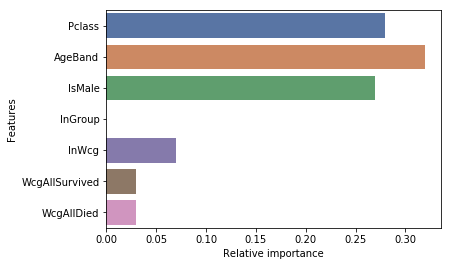

In [49]:
g = sns.barplot(x=ada_best.feature_importances_, y=test.columns, orient='h')
_ = g.set_xlabel('Relative importance')
_ = g.set_ylabel('Features')

### 5.2.5 Extra Trees <a class="anchor" id="extra-trees"></a>

In [50]:
etc = ExtraTreesClassifier(random_state=random_state, n_estimators=n_estimators)
rand_param = {
    'bootstrap': [True, False],
    'max_depth': np.append(randint(1, 10).rvs(10), None),
    'max_features': randint(1, X_train.shape[1]), # From 1 to number of features is a good range
    'min_samples_split': randint(2, 10)
}

etc_search = RandomizedSearchCV(etc, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
etc_search.fit(X_train, Y_train)
report(etc_search.cv_results_)

etc_best = etc_search.best_estimator_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   57.6s finished


Model with rank: 1
Mean validation score: 0.8619 (std: 0.0353)
Parameters: {'max_depth': 5, 'max_features': 4, 'bootstrap': True, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: 0.8619 (std: 0.0353)
Parameters: {'max_depth': 4, 'max_features': 1, 'bootstrap': False, 'min_samples_split': 9}

Model with rank: 1
Mean validation score: 0.8619 (std: 0.0353)
Parameters: {'max_depth': 4, 'max_features': 4, 'bootstrap': True, 'min_samples_split': 2}



Feature importance:

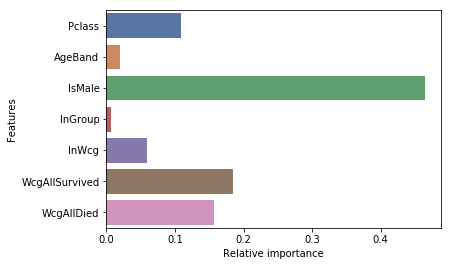

In [51]:
g = sns.barplot(x=etc_best.feature_importances_, y=test.columns, orient='h')
_ = g.set_xlabel('Relative importance')
_ = g.set_ylabel('Features')

## 5.3 Ensemble modeling <a class="anchor" id="ensemble"></a>

We can combine the best estimators into a single model using a Soft Voting/Majority Rule classifier (`VotingClassifier`). Ensembles can only improve over individual models if they are not highly correlated. So, let's start by evaluating the Jaccard similarity between the predictions of each individual model.

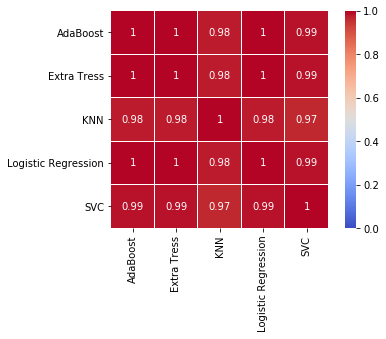

In [52]:
logreg_pred = logreg_best.predict(X_test)
svc_pred = svc_best.predict(X_test)
knn_pred = knn_best.predict(X_test)
ada_pred = ada_best.predict(X_test)
etc_pred = etc_best.predict(X_test)

# Make a dataframe with the predictions from all models
pred_df = pd.DataFrame({
    'Logistic Regression': logreg_pred,
    'SVC': svc_pred,
    'KNN': knn_pred,
    'AdaBoost': ada_pred,
    'Extra Tress': etc_pred
})

jsim_df = pd.DataFrame(np.nan, columns=pred_df.columns, index=pred_df.columns)
for i in pred_df.columns:
    for j in pred_df.loc[:, i:].columns:
        jsim_df.loc[i, j] = jaccard_similarity_score(pred_df[i], pred_df[j])
        jsim_df.loc[j, i] = jsim_df.loc[i, j]

_ = sns.heatmap(jsim_df, linewidths=0.1, vmax=1.0, vmin=0, square=True, linecolor='white', annot=True, cmap='coolwarm')

Doesn't look good for ensembling, the predictions are very similar between the models; therefore, the ensemble will output essentially the same predictions.

As a learning experience, let's create the ensemble anyway and check how it performs.

In [53]:
estimators = [
    ('Logistic Regression', logreg_best),
    ('SVC', svc_best),
    ('KNN', knn_best),
    ('AdaBoost', ada_best),
    ('Extra Trees', etc_best)
]

eclf = VotingClassifier(estimators=estimators)
ensemble_param = {'voting': ['hard', 'soft']}

eclf_search = GridSearchCV(eclf, param_grid=ensemble_param, cv=k_folds, n_jobs=4, verbose=1)
eclf_search.fit(X_train, Y_train)
report(eclf_search.cv_results_)

eclf_best = eclf_search.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.8s finished


Model with rank: 1
Mean validation score: 0.8620 (std: 0.0353)
Parameters: {'voting': 'hard'}

Model with rank: 1
Mean validation score: 0.8620 (std: 0.0353)
Parameters: {'voting': 'soft'}



Just as expected, it performs about the same as our individual models.

# 6. Predictions and submission <a class="anchor" id="submission"></a>

We can now generate predictions and the submission file using our best model. Since we are using `RandomizedSearchCV` we don't always get the same optimal hyperparameters. The best cross-validation score I have seen is a `KNeighborsClassifier` with the following hyper-parameters:
- `leaf_size = 3`
- `weights = 'uniform'`
- `n_neighbors = 19`

In [54]:
best_model = KNeighborsClassifier(leaf_size=3, weights='uniform', n_neighbors=19)
score = cross_val_score(best_model, X_train, Y_train, cv=k_folds, n_jobs=4)
best_model.fit(X_train, Y_train)
print("Cross-validation accuracy: {0:.4f}".format(score.mean()))

# Prediction
best_pred = best_model.predict(X_test)

Cross-validation accuracy: 0.8630


Now we submit the predictions,

In [55]:
submission_df = pd.DataFrame({'PassengerId': _test['PassengerId'], 'Survived': best_pred})
submission_df.to_csv("submission.csv", index=False)

Also store the training and test datasets

In [56]:
train.to_csv("submission_train.csv", index=False)
test.to_csv("submission_test.csv", index=False)